In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, Embedding, MaxPooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pylab
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-03-21 00:55:18--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.91MB/s    in 0.3s    

2023-03-21 00:55:18 (1.91 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
#Drop the unnecessary columns
df = df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#Rename the columns
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#Create binary label
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [8]:
#Split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [9]:
#Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [10]:
#Get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7242 unique tokens.


In [11]:
#pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

#get sequence length
T = data_train.shape[1]



Shape of data train tensor: (3733, 189)


In [12]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


Build CNN Model

In [15]:
#get to choose embedding dimensionality
D = 20

'''
Note: we actually want to the size of the embedding to (V+1) x D,
becuase the first index starts from 1 and not 0.
Thus, if the final index of the ebedding matrix is V,
then it actually must have size V + 1
'''

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

Compile and Fit

In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train, 
    Ytrain, 
    epochs=5,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/5
117/117 [==============================] - 5s 24ms/step - loss: 0.4036 - accuracy: 0.8586 - val_loss: 0.2836 - val_accuracy: 0.8755
Epoch 2/5
117/117 [==============================] - 3s 22ms/step - loss: 0.1421 - accuracy: 0.9421 - val_loss: 0.0649 - val_accuracy: 0.9826
Epoch 3/5
117/117 [==============================] - 3s 22ms/step - loss: 0.0202 - accuracy: 0.9949 - val_loss: 0.0565 - val_accuracy: 0.9875
Epoch 4/5
117/117 [==============================] - 5s 39ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0773 - val_accuracy: 0.9864
Epoch 5/5
117/117 [==============================] - 5s 43ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0615 - val_accuracy: 0.9869


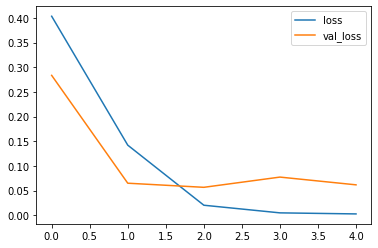

In [17]:
#Plot loss per iteration
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()

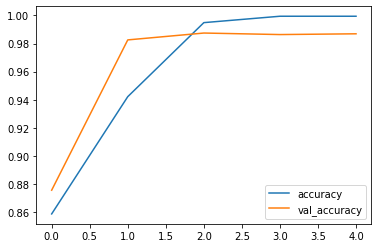

In [18]:
#Plot accuracy per iteration
plt.plot(r.history['accuracy'], label="accuracy")
plt.plot(r.history['val_accuracy'], label="val_accuracy")
plt.legend()